In [20]:
import s3fs
import fsspec
import xarray as xr
import rasterio
from ndpyramid import pyramid_reproject
import os
import boto3
import numpy as np
import rioxarray as rio
import matplotlib

VERSION = 2
LEVELS = 6
PIXELS_PER_TILE = 128

In [2]:
# Generate credentials
session_name='read-zarr'
aws_profile=''
aws_account_id=''
aws_role_name=''
boto3.setup_default_session(profile_name={aws_profile})
sts_client = boto3.client('sts')
assumed_role_object = sts_client.assume_role(
    RoleArn=f"arn:aws:iam::{aws_account_id}:role/{aws_role_name}",
    RoleSessionName=session_name
)

credentials = assumed_role_object['Credentials']
access_key_id = assumed_role_object['Credentials']['AccessKeyId']
secret_access_key = assumed_role_object['Credentials']['SecretAccessKey']
session_token = assumed_role_object['Credentials']['SessionToken']

In [3]:
s3 = s3fs.S3FileSystem(
    key=access_key_id,
    secret=secret_access_key,
    token=session_token
)

In [4]:
root= 'veda-data-store-staging/EIS/zarr/SPL3SMP.zarr'
store = s3fs.S3Map(root=root, s3=s3)
store
ds = xr.open_zarr(store=store)

In [5]:
soil_moisture = ds['soil_moisture'].to_dataset(name='soil_moisture').squeeze()
soil_moisture

,Array,Chunk
Bytes,2.30 GiB,3.81 MiB
Shape,"(406, 964, 1579)","(100, 100, 100)"
Count,801 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [8]:
first_year = np.datetime64(soil_moisture.datetime.min().values, 'D')
last_year = np.datetime64(soil_moisture.datetime.max().values, 'D')

first_year, last_year

(numpy.datetime64('2018-01-01'), numpy.datetime64('2022-06-01'))

In [41]:
np.set_printoptions(threshold=np.inf)
dates = np.arange(first_year, last_year, dtype='datetime64[M]')
print(dates)

['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02'
 '2019-03' '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09'
 '2019-10' '2019-11' '2019-12' '2020-01' '2020-02' '2020-03' '2020-04'
 '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10' '2020-11'
 '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05' '2021-06'
 '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12' '2022-01'
 '2022-02' '2022-03' '2022-04' '2022-05']


In [10]:
subset = soil_moisture.sel(datetime=dates.astype('datetime64[ns]'), method="nearest")
subset

,Array,Chunk
Bytes,79.13 MiB,156.25 kiB
Shape,"(406, 964, 53)","(100, 100, 4)"
Count,1601 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [12]:
subset = subset.rename({'easting_m': 'x', 'northing_m': 'y'})
subset = subset.rio.write_crs("epsg:6933", inplace=True).transpose(
    'datetime', 'y', 'x')
subset

In [14]:
%%time
subset = subset.rio.reproject("EPSG:4326")

CPU times: user 9.41 s, sys: 2 s, total: 11.4 s
Wall time: 30.3 s


In [15]:
subset['datetime'] = range(len(subset['datetime']))
subset = subset.rename({'datetime': 'day'})
subset['day'] = subset.day.astype('float64')

In [16]:
subset

<xarray.Dataset>
Dimensions:        (x: 2214, y: 1046, day: 53)
Coordinates:
  * x              (x) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * y              (y) float64 84.96 84.8 84.64 84.48 ... -84.64 -84.8 -84.96
  * day            (day) float64 0.0 1.0 2.0 3.0 4.0 ... 49.0 50.0 51.0 52.0
    spatial_ref    int64 0
Data variables:
    soil_moisture  (day, y, x) float32 nan nan nan nan nan ... nan nan nan nan

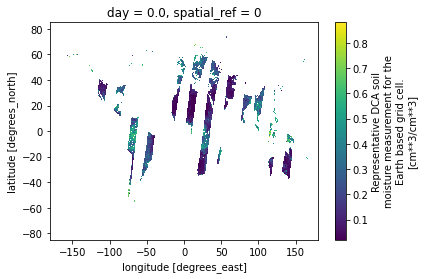

In [17]:
subset.soil_moisture[0].plot()

In [18]:
subset.soil_moisture[0].max().values

array(0.88049334, dtype=float32)

In [21]:
%%time
dt = pyramid_reproject(subset, levels=LEVELS)

CPU times: user 39 s, sys: 10.2 s, total: 49.2 s
Wall time: 52.2 s


In [22]:
save_path = "data/smap-soil-moisture-daily.zarr"
dt.to_zarr(save_path, consolidated=True)
# Upload to S3!!!

In [23]:
ds = xr.open_zarr(save_path, group='1', consolidated=True)
ds.day.min().values

array(0., dtype=float32)